# Task 1 Ptbdb Data (VanillaCNN,VanillaRNN)

## Loading modules
Note we load models, data and plotting function from models.ipynb and helper_functions.ipynb

In [1]:
import itertools

In [2]:
import io
import numpy as np
import os
import pandas as pd
import pathlib
import shutil
import tensorflow as tf
from inspect import signature
from keras import losses
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from matplotlib import pyplot as plt
from pathlib import Path
from scipy import stats
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    f1_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [3]:
%load_ext tensorboard
# For evaluation

## Load needed functions

### Models

In [17]:
# Similar model to base line, added BatchNorm, adjusted kernel_sizes, filter_sizes and pooling layers
def CNN(nclass, time_steps, features, af):
    inputs = keras.layers.Input([187,1])
    x = keras.layers.Conv1D(filters=16, kernel_size=3, strides=1)(inputs)
    x = keras.layers.Conv1D(filters=16, kernel_size=9, strides=1)(x)

    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.ReLU()(x)
    x=keras.layers.MaxPool1D(pool_size=5, strides=1)(x)

    x=keras.layers.Conv1D(filters=256, kernel_size=5, strides=1)(x)
    x=keras.layers.Conv1D(filters=92, kernel_size=9, strides=1)(x)
    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.ReLU()(x)
    x=keras.layers.MaxPool1D(pool_size=5, strides=1)(x)

    x=keras.layers.Conv1D(filters=184, kernel_size=9, strides=1)(x)
    x=keras.layers.Conv1D(filters=104, kernel_size=3, strides=1)(x)
    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.ReLU()(x)
    x=keras.layers.MaxPool1D(pool_size=5, strides=1)(x)

    x=keras.layers.Flatten()(x)
    x=keras.layers.Dense(1924, activation="relu")(x)
    outputs=keras.layers.Dense(nclass,activation=af)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)    
    model.summary()

    return model


def RNN(nclass, time_steps, features, af):
    model = keras.Sequential([
        keras.layers.LSTM(16, return_sequences=True,
                          input_shape=(time_steps, features)),
        keras.layers.Dropout(0.5),
        keras.layers.BatchNormalization(),
        keras.layers.LSTM(32, return_sequences=True),
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),
        keras.layers.LSTM(64, return_sequences=True),
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),
        keras.layers.Flatten(),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(nclass, activation=af)
    ])
    model.summary()
    return model

### Helper functions

In [18]:
def get_model(data, model_name):
    time_steps = 187
    features = 1
    if data == "mitbih":
        number_class = 5
        activation_function = "softmax"
        loss = losses.sparse_categorical_crossentropy
    elif data == "ptbdb":
        number_class = 1
        activation_function = "sigmoid"
        loss = losses.binary_crossentropy
    if model_name == "ResNet":
        np.expand_dims(X_train, -1)
        np.expand_dims(Y_train, -1)
        model = ResNet(number_class, time_steps, features, activation_function)
    elif model_name == "CNN":
        model = CNN(number_class, time_steps, features, activation_function)
    elif model_name == "CNNDML":
        model = CNNDML(number_class, time_steps, features, activation_function)
    elif model_name == "RNN":
        model = RNN(number_class, time_steps, features, activation_function)
    elif model_name == "RNNDML":
        model = RNNDML(number_class, time_steps, features, activation_function)
    elif model_name == "BaseLine":
        model = BaseLine(number_class, time_steps,
                         features, activation_function)

    elif model_name == "Transformer":
        model = Transformer(number_class, time_steps,
                            features, activation_function)
    elif model_name == "LSTM_FCN":
        model = LSTM_FCN(number_class, time_steps,
                         features, activation_function)
    elif model_name == "Encoder":
        model = Encoder(number_class, time_steps,
                        features, activation_function)
    elif model_name == "EncoderDML":
        model = EncoderDML(number_class, time_steps,
                           features, activation_function)
    elif model_name == "RNNAdvanced":
        model = RNNAdvanced(number_class, time_steps,
                            features, activation_function)
    elif model_name == "CNN2":
        model = CNN2(number_class, time_steps, features, activation_function)
    return model, loss


def get_data(data, data_path, zscore=True):
    if data == "mitbih":
        df_train = pd.read_csv(data_path+"/mitbih_train.csv", header=None)
        df_train = df_train.sample(frac=1)
        df_test = pd.read_csv(data_path+"/mitbih_test.csv", header=None)

        Y = np.array(df_train[187].values).astype(np.int8)
        X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

        Y_test = np.array(df_test[187].values).astype(np.int8)
        X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

    elif data == "ptbdb":
        df_1 = pd.read_csv(data_path+"/ptbdb_normal.csv", header=None)
        df_2 = pd.read_csv(data_path+"/ptbdb_abnormal.csv", header=None)
        df = pd.concat([df_1, df_2])

        df_train, df_test = train_test_split(
            df, test_size=0.2, random_state=1337, stratify=df[187])

        Y = np.array(df_train[187].values).astype(np.int8)
        X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

        Y_test = np.array(df_test[187].values).astype(np.int8)
        X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

    if zscore:
        X = stats.zscore(X, axis=1)
        X_test = stats.zscore(X_test, axis=1)

    return X, X_test, Y, Y_test


def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
    test_pred = model.predict(X_test)
    test_pred = (test_pred > 0.5).astype(np.int8)
    cm = metrics.confusion_matrix(Y_test, test_pred)
    normalize = False
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    figure = plt.figure(figsize=(9, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(model_name+" Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

    buf = io.BytesIO()
    plt.savefig(buf, format='png')

    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)

    # Log the confusion matrix as an image summary.
    file_writer = tf.summary.create_file_writer(tensorboard_path)
    with file_writer.as_default():
        tf.summary.image("Confusion Matrix", image, step=epoch)


def log_auroc(epoch, logs):
  # Use the model to predict the values from the validation dataset.
    pred_test = model.predict(X_test)
    pred_test = (pred_test > 0.5).astype(np.int8)

    fpr, tpr, thresholds = roc_curve(Y_test, pred_test)
    figure = plt.figure(figsize=(9, 6))
    plt.plot(
        fpr,
        tpr,
        color="b",
        label=r"Model (AUC = %0.3f)" % (roc_auc_score(Y_test, pred_test)),
        lw=2,
        alpha=0.8,
    )
    plt.plot(
        [0, 1],
        [0, 1],
        linestyle="--",
        lw=2,
        color="r",
        label="Luck (AUC = 0.5)",
        alpha=0.8,
    )
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(model_name+"-AUROC")
    plt.legend(loc="lower right")

    buf = io.BytesIO()
    plt.savefig(buf, format='png')

    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)

    # Log the auroc as an image summary.
    file_writer = tf.summary.create_file_writer(tensorboard_path)
    with file_writer.as_default():
        tf.summary.image("AUROC", image, step=epoch)


def log_auprc(epoch, logs):
  # Use the model to predict the values from the validation dataset.
    pred_test = model.predict(X_test)
    pred_test = (pred_test > 0.5).astype(np.int8)

    average_precision = average_precision_score(Y_test, pred_test)
    precision, recall, _ = precision_recall_curve(Y_test, pred_test)
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = (
        {"step": "post"} if "step" in signature(
            plt.fill_between).parameters else {}
    )

    figure = plt.figure(figsize=(9, 6))
    plt.step(recall, precision, color="b", alpha=0.2, where="post")
    plt.fill_between(recall, precision, alpha=0.2, color="b", **step_kwargs)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(model_name+"-AUPRC: AP={0:0.3f}".format(average_precision))

    buf = io.BytesIO()
    plt.savefig(buf, format='png')

    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)

    # Log the auroc as an image summary.
    file_writer = tf.summary.create_file_writer(tensorboard_path)
    with file_writer.as_default():
        tf.summary.image("AUPRC", image, step=epoch)


def plot_roc(y_actual, y_pred):
    """
    Function to plot AUC-ROC curve
    """
    fpr, tpr, thresholds = roc_curve(y_actual, y_pred)
    plt.figure(figsize=(9, 6))
    plt.plot(
        fpr,
        tpr,
        color="b",
        label=r"Model (AUC = %0.2f)" % (roc_auc_score(y_actual, y_pred)),
        lw=2,
        alpha=0.8,
    )
    plt.plot(
        [0, 1],
        [0, 1],
        linestyle="--",
        lw=2,
        color="r",
        label="Luck (AUC = 0.5)",
        alpha=0.8,
    )
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()


def plot_precisionrecall(y_actual, y_pred):
    """
    Function to plot AUC-ROC curve
    """
    average_precision = average_precision_score(y_actual, y_pred)
    precision, recall, _ = precision_recall_curve(y_actual, y_pred)
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = (
        {"step": "post"} if "step" in signature(
            plt.fill_between).parameters else {}
    )

    plt.figure(figsize=(9, 6))
    plt.step(recall, precision, color="b", alpha=0.2, where="post")
    plt.fill_between(recall, precision, alpha=0.2, color="b", **step_kwargs)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title("Precision-Recall curve: AP={0:0.2f}".format(average_precision))


def plot_confusion_matrix(
    y_true,
    y_pred,
    classes,
    normalize=False,
    title="Confusion matrix",
    cmap=plt.cm.Blues,
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = metrics.confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)
    plt.figure(figsize=(9, 6))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


def get_transfer_model(model):
    model.trainable = False
    model_input = model.inputs
    model_output = model.layers[-4].output

    X = keras.layers.Dense(32, activation='relu')(model_output)
    X = keras.layers.Dense(32, activation='relu')(X)
    out = keras.layers.Dense(1, activation='sigmoid')(X)

    transfer_model = keras.Model(inputs=model_input, outputs=out)
    return transfer_model


def plot_model_results(model, history, model_path, data, model_name, X_test, Y_test):
    model.load_weights(model_path)
    if model_name == "ResNet":
        X_test = np.expand_dims(X_test, -1)
        Y_test = np.expand_dims(Y_test, -1)
        model.evaluate(X_test, Y_test)
    if data == "mitbih":
        mitbih_dict = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}
        pred_test = model.predict(X_test)
        pred_test = np.argmax(pred_test, axis=-1)

        pd.DataFrame(history.history).plot(figsize=(8, 5))

        f1 = f1_score(Y_test, pred_test, average="macro")
        acc = accuracy_score(Y_test, pred_test)

        print("Test F1 score : {:.4f}".format(np.mean(f1)))
        print("Test ACC score : {:.4f}".format(np.mean(acc)))

        plot_confusion_matrix(
            Y_test,
            pred_test,
            [*mitbih_dict],
            normalize=True,
            title="Confusion matrix",
            cmap=plt.cm.Blues)
    elif data == "ptbdb":
        ptbdb_dict = {'Normal': 0, 'Abnormal': 1}
        pred_test = model.predict(X_test)
        pred_test = (pred_test > 0.5).astype(np.int8)
        f1 = f1_score(Y_test, pred_test, average="macro")
        acc = accuracy_score(Y_test, pred_test)
        print("Test F1 score : {:.4f}".format(np.mean(f1)))
        print("Test ACC score : {:.4f}".format(np.mean(acc)))
        plot_confusion_matrix(
            Y_test,
            pred_test,
            [*ptbdb_dict],
            normalize=False,
            title="Confusion matrix",
            cmap=plt.cm.Blues)
        plot_roc(Y_test, pred_test)
        plot_precisionrecall(Y_test, pred_test)

#### Define path, where data is stored and where you want the models and results stored!

In [19]:
working_path = pathlib.Path().resolve()
path_object = Path(working_path)
parent_path = path_object.parent
model_path_parent = os.path.join(parent_path, "03-Models/01-Ptbdb/01-Task1")
data_path = os.path.join(parent_path, "01-Data")
tensorboard_path_parent = os.path.join(
    parent_path, "04-Logs/01-Ptbdb/01-Task1")

## VanillaCNN
### Compile and run

In [20]:
# Always clear as keras backend is tedious
tf.keras.backend.clear_session()

# Load the prefered Model and data which will be feeded
data = "ptbdb"
model_name = "CNN"
model, loss = get_model(data, model_name)

# will be z-Scored
X_train, X_test, Y_train, Y_test = get_data(data, data_path, zscore=True)
ptbdb_dict = {'Normal': 0, 'Abnormal': 1}
classes = [*ptbdb_dict]

# Define Hyperparameters
epochs = 40
learning_rate = 0.0005
batch_size = 64
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = loss


# Define Callbacks (taken from baseline file)
model_path = os.path.join(model_path_parent, model_name+"_"+data+"_weights.h5")
tensorboard_path = os.path.join(tensorboard_path_parent, model_name+"_"+data)
file_writer = tf.summary.create_file_writer(tensorboard_path)


checkpoint = ModelCheckpoint(
    model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_accuracy",
                      mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(
    monitor="val_accuracy", mode="max", patience=3, verbose=2)
# uncomment if you want to track in tensorboard
tbc = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path)

# Also we add plot callbacks to get pretty evolution of intresting plots over each epochs
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
auroc_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_auroc)
auprc_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_auprc)

callbacks_list = [
    checkpoint,
    early,
    redonplat,
    tbc,
    cm_callback,
    auroc_callback,
    auprc_callback,
]

# delete tensorboard folder if already exists, so no overlap
try:
    shutil.rmtree(tensorboard_path)
except:
    pass

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 187, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 185, 16)           64        
                                                                 
 conv1d_1 (Conv1D)           (None, 177, 16)           2320      
                                                                 
 batch_normalization (BatchN  (None, 177, 16)          64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 177, 16)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 173, 16)          0         
 )                                                           

In [21]:
# Compile and Run
METRICS = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]
model.compile(optimizer=optimizer, loss=loss, metrics=METRICS)

history = model.fit(X_train, Y_train, validation_split=0.1, epochs=epochs,
                    shuffle=True, batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/40
164/164 [==============================] - ETA: 0s - loss: 0.5860 - accuracy: 0.8607 - auc: 0.8938 - prc: 0.9413
Epoch 1: val_accuracy improved from -inf to 0.80000, saving model to C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\03-Models/01-Ptbdb/01-Task1\CNN_ptbdb_weights.h5
164/164 [==============================] - 10s 46ms/step - loss: 0.5860 - accuracy: 0.8607 - auc: 0.8938 - prc: 0.9413 - val_loss: 0.3521 - val_accuracy: 0.8000 - val_auc: 0.9162 - val_prc: 0.9663 - lr: 5.0000e-04
Epoch 2/40
163/164 [============================>.] - ETA: 0s - loss: 0.1568 - accuracy: 0.9385 - auc: 0.9802 - prc: 0.9916
Epoch 2: val_accuracy improved from 0.80000 to 0.90472, saving model to C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\03-Models/01-Ptbdb/01-Task1\CNN_ptbdb_weights.h5
164/164 [==============================] - 6s 37ms/step - loss: 0.1563 - accuracy: 0.9386 - auc: 0.9803 - prc: 0.9916 - val_loss: 0.2088 - val_accuracy: 0.9047 - val_auc: 0.9875 - val_prc: 0.

### Results CNN

Test F1 score : 0.9919
Test ACC score : 0.9935
Confusion matrix, without normalization
[[ 797   12]
 [   7 2095]]


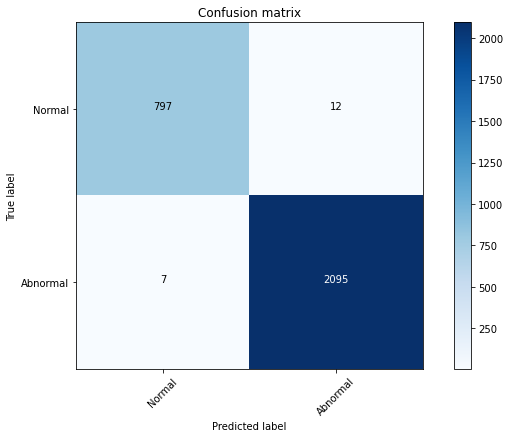

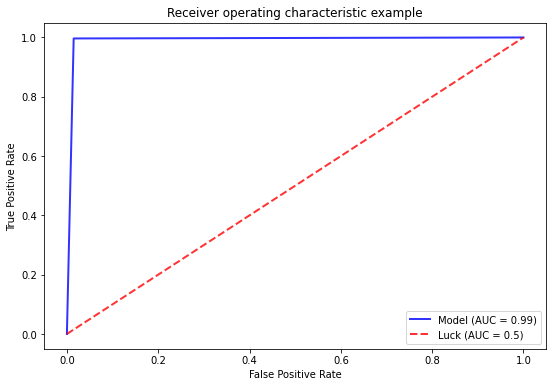

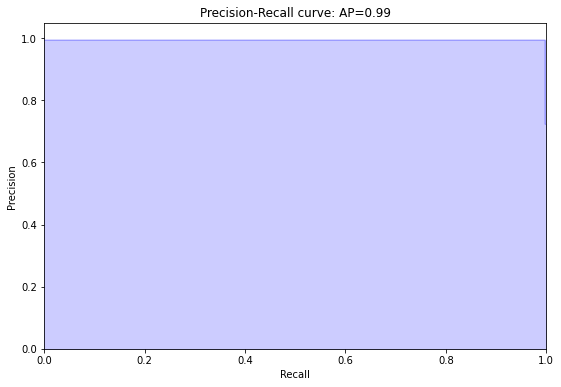

In [22]:
plot_model_results(model, history, model_path,
                   data, model_name, X_test, Y_test)

In [23]:
model_path = os.path.join(model_path_parent, model_name+"_"+data)
model.save(model_path)

INFO:tensorflow:Assets written to: C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\03-Models/01-Ptbdb/01-Task1\CNN_ptbdb\assets


## VanillaRNN
### Compile and run

In [24]:
# Always clear as keras backend is tedious
tf.keras.backend.clear_session()

# Load the prefered Model and data which will be feeded
data = "ptbdb"
model_name = "RNN"
model, loss = get_model(data, model_name)

# will be z-Scored
X_train, X_test, Y_train, Y_test = get_data(data, data_path, zscore=True)
ptbdb_dict = {'Normal': 0, 'Abnormal': 1}
classes = [*ptbdb_dict]

# Define Hyperparameters
epochs = 40
learning_rate = 0.0005
batch_size = 64
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = loss


# Define Callbacks (taken from baseline file)
model_path = os.path.join(model_path_parent, model_name+"_"+data+"_weights.h5")
tensorboard_path = os.path.join(tensorboard_path_parent, model_name+"_"+data)
file_writer = tf.summary.create_file_writer(tensorboard_path)


checkpoint = ModelCheckpoint(
    model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_accuracy",
                      mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(
    monitor="val_accuracy", mode="max", patience=3, verbose=2)
# uncomment if you want to track in tensorboard
tbc = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path)

# Also we add plot callbacks to get pretty evolution of intresting plots over each epochs
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
auroc_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_auroc)
auprc_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_auprc)

callbacks_list = [
    checkpoint,
    early,
    redonplat,
    tbc,
    cm_callback,
    auroc_callback,
    auprc_callback,
]

# delete tensorboard folder if already exists, so no overlap
try:
    shutil.rmtree(tensorboard_path)
except:
    pass

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 187, 16)           1152      
                                                                 
 dropout (Dropout)           (None, 187, 16)           0         
                                                                 
 batch_normalization (BatchN  (None, 187, 16)          64        
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 187, 32)           6272      
                                                                 
 dropout_1 (Dropout)         (None, 187, 32)           0         
                                                                 
 batch_normalization_1 (Batc  (None, 187, 32)          128       
 hNormalization)                                        

In [25]:
# Compile and Run
METRICS = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]
model.compile(optimizer=optimizer, loss=loss, metrics=METRICS)

history = model.fit(X_train, Y_train, validation_split=0.1, epochs=epochs,
                    shuffle=True, batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/40
163/164 [============================>.] - ETA: 0s - loss: 0.4831 - accuracy: 0.8203 - auc: 0.8666 - prc: 0.9364
Epoch 1: val_accuracy improved from -inf to 0.76309, saving model to C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\03-Models/01-Ptbdb/01-Task1\RNN_ptbdb_weights.h5
164/164 [==============================] - 20s 96ms/step - loss: 0.4825 - accuracy: 0.8204 - auc: 0.8669 - prc: 0.9365 - val_loss: 0.5525 - val_accuracy: 0.7631 - val_auc: 0.8760 - val_prc: 0.9482 - lr: 5.0000e-04
Epoch 2/40
164/164 [==============================] - ETA: 0s - loss: 0.2576 - accuracy: 0.8897 - auc: 0.9483 - prc: 0.9796
Epoch 2: val_accuracy improved from 0.76309 to 0.79142, saving model to C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\03-Models/01-Ptbdb/01-Task1\RNN_ptbdb_weights.h5
164/164 [==============================] - 14s 86ms/step - loss: 0.2576 - accuracy: 0.8897 - auc: 0.9483 - prc: 0.9796 - val_loss: 0.3962 - val_accuracy: 0.7914 - val_auc: 0.9138 - val_prc: 0

164/164 [==============================] - 14s 85ms/step - loss: 0.0207 - accuracy: 0.9932 - auc: 0.9995 - prc: 0.9997 - val_loss: 0.0430 - val_accuracy: 0.9828 - val_auc: 0.9984 - val_prc: 0.9994 - lr: 5.0000e-04
Epoch 19/40
163/164 [============================>.] - ETA: 0s - loss: 0.0173 - accuracy: 0.9942 - auc: 0.9995 - prc: 0.9998
Epoch 19: val_accuracy improved from 0.98283 to 0.98541, saving model to C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\03-Models/01-Ptbdb/01-Task1\RNN_ptbdb_weights.h5
164/164 [==============================] - 14s 83ms/step - loss: 0.0173 - accuracy: 0.9943 - auc: 0.9995 - prc: 0.9998 - val_loss: 0.0511 - val_accuracy: 0.9854 - val_auc: 0.9973 - val_prc: 0.9982 - lr: 5.0000e-04
Epoch 20/40
164/164 [==============================] - ETA: 0s - loss: 0.0139 - accuracy: 0.9949 - auc: 0.9999 - prc: 0.9999
Epoch 20: val_accuracy did not improve from 0.98541
164/164 [==============================] - 14s 84ms/step - loss: 0.0139 - accuracy: 0.9949 - a

### Results RNN

Test F1 score : 0.9850
Test ACC score : 0.9880
Confusion matrix, without normalization
[[ 790   19]
 [  16 2086]]


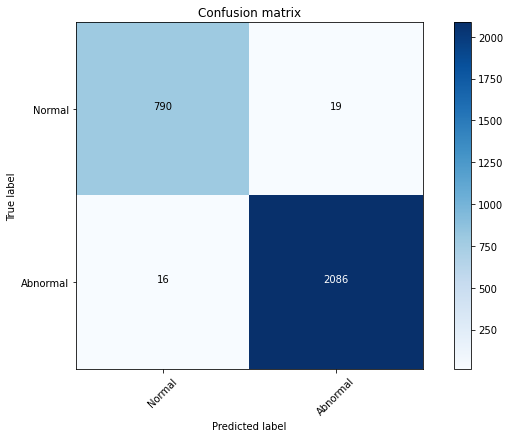

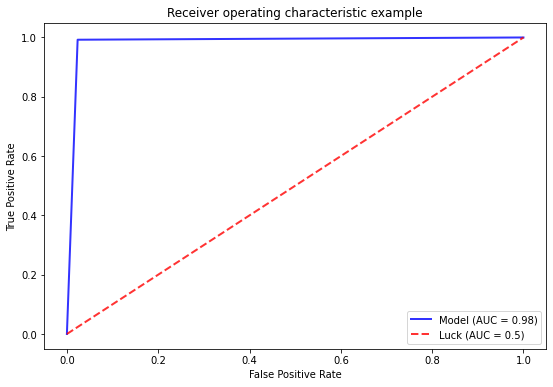

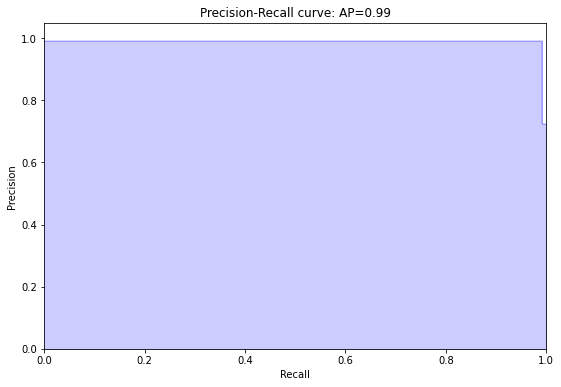

In [26]:
plot_model_results(model, history, model_path,
                   data, model_name, X_test, Y_test)

In [27]:
model_path = os.path.join(model_path_parent, model_name+"_"+data)
model.save(model_path)

INFO:tensorflow:Assets written to: C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\03-Models/01-Ptbdb/01-Task1\RNN_ptbdb\assets


INFO:tensorflow:Assets written to: C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\03-Models/01-Ptbdb/01-Task1\RNN_ptbdb\assets


In [28]:
## Visualizaitons in tensorboard

In [29]:
# Please have a look at in Tensorboard with all needed figures,
# change mode to light on half-moon icon to see labels and move circle above cm to see evolution for each epoch
# You can also look at the results in your browser, see tensorboard documentation
# AUPRC and AUROC in section "Scalars" are calc. with validation set, images are calcualted with test set.

# At parent path, so both Results are compared to each other
%tensorboard --logdir {tensorboard_path_parent.replace(os.sep, '/')}
# Or go into your console and type: tensorboard --logdir='...\Submission\04-Logs\01-Ptbdb'

## Results